# Problem Set 2, due April 26 at 3:30pm.

## Introduction to the assignment

For this assignment, you will be using data from the [Progresa program](http://en.wikipedia.org/wiki/Oportunidades), a government social assistance program in Mexico. This program, as well as the details of its impact, are described in the paper "[School subsidies for the poor: evaluating the Mexican Progresa poverty program](http://www.sciencedirect.com/science/article/pii/S0304387803001858)", by Paul Shultz (available on Canvas). Please familiarize yourself with the PROGRESA program before beginning this problem set, so you have a rough sense of where the data come from and how they were generated. If you just proceed into the problem set without understanding Progresa or the data, it will be very difficult!

The goal of this problem set is to implement some of the basic econometric techniques that you are learning in class to measure the impact of Progresa on secondary school enrollment rates. The timeline of the program was:

 * Baseline survey conducted in 1997
 * Intervention begins in 1998, "Wave 1" of data collected in 1998
 * "Wave 2 of data" collected in 1999
 * Evaluation ends in 2000, at which point the control villages were treated. 
 
When you are ready, download the progresa_sample.csv data from Canvas. The data are actual data collected to evaluate the impact of the Progresa program.  In this file, each row corresponds to an observation taken for a given child for a given year. There are two years of data (1997 and 1998), and just under 40,000 children who are surveyed in both years.  For each child-year observation, the following variables are collected:

| Variable name | Description|
|------|------|
|year	  |year in which data is collected
|sex	  |male = 1|
|indig	  |indigenous = 1|
|dist_sec |nearest distance to a secondary school|
|sc	      |enrolled in school in year of survey|
|grc      |grade enrolled|
|fam_n    |family size|
|min_dist |	min distance to an urban center|
|dist_cap |	min distance to the capital|
|poor     |	poor = "pobre"|
|progresa |treatment = "basal"|
|hohedu	  |years of schooling of head of household|
|hohwag	  |monthly wages of head of household|
|welfare_index|	welfare index used to classify poor|
|hohsex	|gender of head of household (male=1)|
|hohage	|age of head of household|
|age	|years old|
|folnum	|individual id|
|village|	village id|
|sc97	|schooling in 1997|

---

## Part 1: Descriptive analysis

### 1.1	Summary Statistics

Present summary statistics (mean and standard deviation) for all of the demographic variables in the dataset (i.e., everything except year, folnum, village). Present these in a single table alphabetized by variable name. Do NOT simply expect the grader to scroll through your output!

In [1]:
# Imports
%matplotlib inline
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy.stats
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind
import statsmodels.api as sm

from sklearn import linear_model as lm
from sklearn.metrics import r2_score

In [2]:
#Read CSV
progresa = pd.read_csv('progresa_sample.csv')

In [209]:
#Processing Columns
cols = (progresa.columns).tolist()

cols.remove('year')
cols.remove('folnum')
cols.remove('village')
cols.remove('poor')
cols.remove('progresa')

progresa['Poor_int'] = np.nan
progresa.loc[progresa['poor'] == 'pobre', 'Poor_int'] = 1
progresa.loc[progresa['poor'] == 'no pobre', 'Poor_int'] = 0

progresa['Progresa_int'] = np.nan
progresa.loc[progresa['progresa'] == 'basal', 'Progresa_int'] = 1
progresa.loc[progresa['progresa'] == 0, 'Progresa_int'] = 0


#Making new Columns
firstCol = [progresa[x].count() for x in cols]
secondCol = [ round(progresa[x].mean(), 2) for x in cols]
thirdCol = [ round(progresa[x].std(), 2) for x in cols]
fourthCol = [ round(progresa[x].min(),2) for x in cols]
fifthCol = [ round(progresa[x].median(),2) for x in cols]
sixthCol = [ round(progresa[x].max(),2) for x in cols]

index = ['Name', 'Number of Non-Missing Values', 'Mean', 'Standard Deviation', 'Min', 'Median', 'Max']

statTable = pd.DataFrame({'Name': cols, 'Number of Non-Missing Values': firstCol, 'Mean': secondCol, 'Standard Deviation': thirdCol, 'Min': fourthCol, 'Median': fifthCol, 'Max':sixthCol})

# Reorder columns to adhere to required format
statTable = statTable[index]
statTable = statTable.sort_values(by=['Name'], ascending=True)
statTable.index += 1

#View Data Frame
statTable

Name  Number of Non-Missing Values    Mean  Standard Deviation  \
17       Poor_int                         77250    0.85                0.36   
18   Progresa_int                         47560    1.00                0.00   
14            age                         77250   11.37                3.17   
8        dist_cap                         77250  147.67               76.06   
3        dist_sec                         77250    2.42                2.23   
6           fam_n                         77250    7.22                2.35   
5             grc                         70701    3.96                2.50   
15          grc97                         77250    3.71                2.57   
13         hohage                         77240   44.44               11.62   
9          hohedu                         77250    2.77                2.66   
12         hohsex                         77230    0.93                0.26   
10         hohwag                         77250  586.99              788.13   
2           indig                         76950    0.30                0.46   
7        min_dist                         77250  103.45               42.09   
4              sc                         68797    0.82                0.38   
16           sc97                         73378    0.81                0.39   
1             sex                         77226    0.51                0.50   
11  welfare_index                         77040  690.35              139.49   

       Min  Median       Max  
17    0.00    1.00      1.00  
18    1.00    1.00      1.00  
14    6.00   11.00     17.00  
8     9.47  132.00    359.77  
3     0.00    2.28     14.88  
6     1.00    7.00     24.00  
5     0.00    4.00     14.00  
15    0.00    4.00     14.00  
13   15.00   43.00     98.00  
9     0.00    2.00     20.00  
12    0.00    1.00      1.00  
10    0.00  500.00  14000.00  
2     0.00    0.00      1.00  
7     9.47  111.23    170.46  
4     0.00    1.00      1.00  
16    0.00    1.00      1.00  
1     0.00    1.00      1.00  
11  180.00  685.00   1294.00

### 1.2 Differences at baseline?

Are the baseline (1997) demographic characteristics **for the poor**  different in treatment and control villages? Hint: Use a T-Test to determine whether there is a statistically significant difference in the average values of each of the variables in the dataset. Focus only on the data from 1997 for individuals who are poor (i.e., poor=='pobre').

Present your results in a single table with the following columns and 14 (or so) rows:

| Variable name | Average value (Treatment villages) | Average value (Control villages) | Difference (Treat - Control) | p-value |
|------|------|------|------|------|
|Male|?|?|?|?|


In [212]:
# From Here: http://stackoverflow.com/questions/13404468/t-test-in-pandas-python
progresaPresent = progresa[(progresa['poor'] == 'pobre') & (progresa['progresa'] == 'basal') & (progresa['year'] == 97)]
progresaAbsent = progresa[(progresa['poor'] == 'pobre') & (progresa['progresa'] != 'basal') & (progresa['year'] == 97)]

#Making Lists
tMean = []
cMean = []
differences = []
p_s = []

# cols.remove('Progresa_int')
# cols.remove('Poor_int')

for col in cols:
    aTMean = np.mean(progresaPresent[col])
    aCMean = np.mean(progresaAbsent[col])
    tMean.append(aTMean)
    cMean.append(aCMean)
    differences.append(aTMean - aCMean)
    Stat, pValue = ttest_ind(progresaPresent[col].dropna(), progresaAbsent[col].dropna())
    p_s.append(pValue)
    
    
index = ['Variable', 'Average value (Treatment villages)', 'Average value (Control villages)', 'Difference (Treat - Control)', 'p-value']

values = [cols, tMean, cMean, differences, p_s]
baselineTable = pd.DataFrame(dict(zip(index, values)))

# Reorder columns to adhere to required format
baselineTable = baselineTable[index]
baselineTable = baselineTable.sort_values(by=['Variable'], ascending=True)
baselineTable.index += 1

#View Data Frame
baselineTable

Variable  Average value (Treatment villages)  \
14            age                           10.716991   
8        dist_cap                          150.829074   
3        dist_sec                            2.453122   
6           fam_n                            7.281327   
5             grc                            3.531599   
15          grc97                            3.531599   
13         hohage                           43.648828   
9          hohedu                            2.663139   
12         hohsex                            0.924656   
10         hohwag                          544.339544   
2           indig                            0.325986   
7        min_dist                          107.152915   
4              sc                            0.822697   
16           sc97                            0.822697   
1             sex                            0.519317   
11  welfare_index                          655.428377   

    Average value (Control villages)  Difference (Treat - Control)  \
14                         10.742023                     -0.025032   
8                         153.769730                     -2.940656   
3                           2.507662                     -0.054540   
6                           7.302469                     -0.021142   
5                           3.543050                     -0.011450   
15                          3.543050                     -0.011450   
13                         44.276918                     -0.628090   
9                           2.590348                      0.072791   
12                          0.922947                      0.001709   
10                        573.163558                    -28.824015   
2                           0.332207                     -0.006222   
7                         103.237854                      3.915060   
4                           0.815186                      0.007511   
16                          0.815186                      0.007511   
1                           0.505052                      0.014265   
11                        659.579100                     -4.150723   

         p-value  
14  4.785594e-01  
8   8.415005e-04  
3   3.569843e-02  
6   4.271039e-01  
5   6.890151e-01  
15  6.890151e-01  
13  1.796243e-06  
9   1.105093e-02  
12  5.711858e-01  
10  3.253835e-04  
2   2.453603e-01  
7   2.358312e-16  
4   9.517806e-02  
16  9.517806e-02  
1   1.219172e-02  
11  1.431016e-03

### 1.3 Interpretation

* A: Are there statistically significant differences between treatment and control villages as baseline? 
* B: Why does it matter if there are differences at baseline?
* C: What does this imply about how to measure the impact of the treatment?

* A: As the majority of the P-Values are less than 0.05, so there is a statistical significance in 1997 accross the treatment groups from the population across the two years; the villages are significantly different from each other.

* B: It matters if there was a difference in the baseline because we want to be able to isolate the effect of any treatment we prescribe and to do so, we need to find populations that are as close to each other as possible. This closeness was measured by the P-Value.

* C: It says that the effect of a manipulated variable on treated population is better elucidated, more observable, when the population's control group is statistically similar. The P-value of a baseline test gives us the probability of the observed differences, or larger differences, if the hypothesis is true and importantly, not an error rate. 


### 1.4 Graphical exploration, part 1

For each level of household head education, compute the average enrollment rate in 1997. Create a scatterplot that shows this relationship. What do you notice?

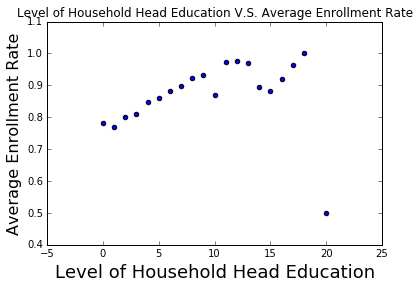

In [214]:
hoheduLevels = progresa['hohedu'].unique()
hoheduLevels = np.sort(hoheduLevels)

hoheduLevels

averageEnrollments = []
for level in hoheduLevels:
    enrollmentAtLevelIn97 = progresa[(progresa['hohedu'] == level)]['sc'].dropna()
    averageEnrollments.append(np.mean(enrollmentAtLevelIn97))

plt.scatter(hoheduLevels, averageEnrollments)
plt.title("Level of Household Head Education V.S. Average Enrollment Rate")
plt.xlabel('Level of Household Head Education', fontsize=18)
plt.ylabel('Average Enrollment Rate', fontsize=16)
plt.show()

I see a positive trend; as the level of household education increases, the average enrollment rate also increases. Interestingly, when the level of Household Head Education was 20, the average enrollemnt rate was 0.5; this can be attributed to having the small observation size of 4.

### 1.5 Graphical exploration, part 2

Create a histogram of village enrollment rates **among poor households in treated villages**, before and after treatment. Specifically, for each village, calculate the average rate of enrollment of poor households in treated villages in 1997, then compute the average rate of enrollment of poor households in treated villages in 1998. Create two separate histograms showing the distribution of these average enrollments rates, one histogram for 1997 and one histogram for 1998. On each histogram, draw a vertical line that intersects the x-axis at the average value (across all households). Does there appear to be a difference? Is this difference statistically significant?

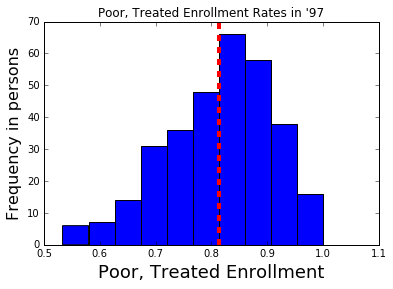

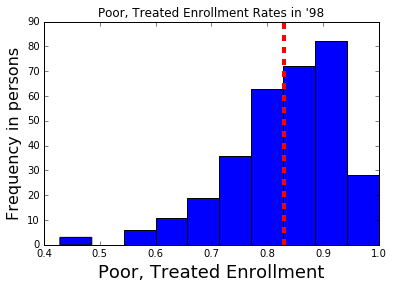

In [18]:
villages = progresa['village'].unique()
villages = np.sort(villages)


averageTreatedEnrollments97 = []
for village in villages:
    poorTreatedEnrollmentsIn97 = np.mean(progresa[(progresa['village'] == village) & (progresa['year'] == 97) & (progresa['poor'] == 'pobre') & (progresa['progresa'] == 'basal')]['sc97'].dropna())
    if not math.isnan(poorTreatedEnrollmentsIn97):
        averageTreatedEnrollments97.append(poorTreatedEnrollmentsIn97)
        
#print(averageTreatedEnrollments97)

averageTreatedEnrollments98 = []
for village in villages:
    poorTreatedEnrollmentsIn98 = np.mean(progresa[(progresa['village'] == village) & (progresa['year'] == 98) & (progresa['poor'] == 'pobre') & (progresa['progresa'] == 'basal')]['sc'].dropna())
    if not math.isnan(poorTreatedEnrollmentsIn98):
        averageTreatedEnrollments98.append(poorTreatedEnrollmentsIn98)
        
#print(averageTreatedEnrollments98)

plt.hist(averageTreatedEnrollments97)
plt.axvline(np.asarray(averageTreatedEnrollments97).mean(), color = 'r', linestyle = 'dashed', linewidth = 4)
plt.title("Poor, Treated Enrollment Rates in '97")
plt.xlabel('Poor, Treated Enrollment', fontsize=18)
plt.ylabel('Frequency in persons', fontsize=16)
plt.show()

plt.hist(averageTreatedEnrollments98)
plt.axvline(np.asarray(averageTreatedEnrollments98).mean(), color = 'r', linestyle = 'dashed', linewidth = 4)
plt.title("Poor, Treated Enrollment Rates in '98")
plt.xlabel('Poor, Treated Enrollment', fontsize=18)
plt.ylabel('Frequency in persons', fontsize=16)
plt.show()

There appears to be a marginal difference between the two populations as the bottom graph, depicting stats from '98, seems to have a value a bit higher than 0.8 whereas the top graph depicting stats from a year earlier has a value an epsilon away from 0.8. It is not yet clear whether these differences are statistically significant as we have not performed any statistical tests to gauge significance; although it does look more right-skewed.

## Part 2: Measuring Impact

Our goal is to estimate the causal impact of the PROGRESA program on the social and economic outcomes of individuals in Mexico. We will focus on the impact of the program on the poor (those with poor=='pobre'), since only the poor were eligible to receive the PROGRESA assistance.

### 2.1 Simple differences: T-test

Begin by estimating the impact of Progresa using "simple differences." Restricting yourself to data from 1998 (after treatment), calculate the average enrollment rate among **poor** households in the Treatment villages and the average enrollment rate among **poor** households in the control villages. Use a t-test to determine if this difference is statistically significant. What do you conclude?

In [215]:
progresaPresent98 = progresa[(progresa['poor'] == 'pobre') & (progresa['progresa'] == 'basal') & (progresa['year'] == 98)]
progresaAbsent98 = progresa[(progresa['poor'] == 'pobre') & (progresa['progresa'] != 'basal') & (progresa['year'] == 98)]


print("Mean of Poor households in Treatment Villages: " + str(np.mean(progresaPresent98['sc'].dropna())))
print("Mean of Poor households in Control Villages: " + str(np.mean(progresaAbsent98['sc'].dropna())))

Stat, pValue98 = ttest_ind(progresaPresent98['sc'].dropna(), progresaAbsent98['sc'].dropna())

print("P-Value between the aformentioned Populations: " + str(pValue98))

Mean of Poor households in Treatment Villages: 0.8464791213954308
Mean of Poor households in Control Villages: 0.807636956730308
P-Value between the aformentioned Populations: 6.63634444752e-17


As the P-Value was 6.63634444752e-17, quite smaller than 0.05, there does seem to be a statistically significant difference between the populations of poor households. If we were to formulate conclusions solely off of this test, we would be forced to reject the null hypothesis that there is no measurable impact in enrollment rate between those who are in the Progresa Program and those who are not.

### 2.2 Simple differences: Regression

Estimate the effects of Progresa on enrollment using a regression model, by regressing the 1998 enrollment rates **of the poor** on treatment assignment. Discuss the following:

* Based on this model, how much did Progresa increase the likelihood of a child enrolling?
* How does your regression estimate compare to your t-test estimate from part 2.1?
* Based on this regression model, can we reject the null hypothesis that the treatment effects are zero? 
* What is the counterfactual assumption underlying this regression?

In [249]:
sliced98 = pd.DataFrame(data=progresa, columns=['year', 'sc', 'poor', 'progresa'])
sliced98 = sliced98[(sliced98['year'] == 98) & (sliced98['poor'] == 'pobre')]
sliced98['progresa'] = sliced98.progresa.apply(lambda x: 1 if x == "basal" else 0)


sliced98 = sliced98.dropna(axis=0)
sliced98


X = sliced98['progresa'].reshape(1, -1)
Y = sliced98['sc'].reshape(1, -1)

r = ln.LinearRegression()
f = r.fit(X.T, Y.T)

print("Coefficient: " + str(f.coef_[0][0]))
print("Intercept: " + str(f.intercept_[0]))

model = sm.formula.ols(formula="sc ~ progresa", data=sliced98).fit()
model.summary()

Coefficient: 0.0388421646651
Intercept: 0.80763695673


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     69.87
Date:                Tue, 25 Apr 2017   Prob (F-statistic):           6.64e-17
Time:                        12:24:49   Log-Likelihood:                -11926.
No. Observations:               27450   AIC:                         2.386e+04
Df Residuals:                   27448   BIC:                         2.387e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.8076      0.004    220.676      0.000         0.800     0.815
progresa       0.0388      0.005      8.359      0.000         0.030     0.048
==============================================================================
Omnibus:                     7638.939   Durbin-Watson:                   1.734
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15767.534
Skew:                          -1.767   Prob(JB):                         0.00
Kurtosis:                       4.140   Cond. No.                         3.01
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can interpret this regresion model in the following way: on average Progresa has increased the likelihood of a child enrolling by approximately 3.88% and but that they would have an 80.8% chance of enrollment if they were not in the Progresa program.

The t-value for my regression estimate was 0.0000, whereas the estimate from 2.1 had more significant figures; they are equivalent

Although there is a non-zero coefficient and the p-value is significantly less than 0.05, we are hesitant in rejecting the null hypothesis that the treatment effects are zero because the strength of the coefficent is very close to zero c.

The counterfactual assumption was Y(1 | T = 0); the outcome under treatment given no treatment is equal to the control group. 

### 2.3 Multiple Regression

Re-run the above regression estimated but this time include a set of control variables. Include, for instance, age, distance to a secondary school, gender, education of household head, welfare index, indigenous, etc.

* How do the controls affect the point estimate of treatment effect?
* How do the controls affect the standard error on the treatment effect? 
* How do you interpret the differences (or similarities) between your estimates of 2.2 and 2.3?

In [260]:
poor = progresa[(progresa['poor'] == 'pobre')]

model = sm.formula.ols(formula="sc ~ progresa + age + dist_sec + sex + hohedu + welfare_index + indig + dist_cap + grc + hohwag + hohsex + fam_n", data=poor).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     2133.
Date:                Tue, 25 Apr 2017   Prob (F-statistic):               0.00
Time:                        12:28:38   Log-Likelihood:                -15498.
No. Observations:               57946   AIC:                         3.102e+04
Df Residuals:                   57933   BIC:                         3.114e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept             1.6409      0.013    128.152      0.000         1.616     1.666
progresa[T.basal]     0.0187      0.003      6.897      0.000         0.013     0.024
age                  -0.0981      0.001   -120.467      0.000        -0.100    -0.097
dist_sec             -0.0062      0.001    -10.031      0.000        -0.007    -0.005
sex                   0.0370      0.003     14.057      0.000         0.032     0.042
hohedu                0.0036      0.001      6.682      0.000         0.003     0.005
welfare_index     -2.384e-05    1.2e-05     -1.981      0.048     -4.74e-05 -2.52e-07
indig                 0.0320      0.003      9.942      0.000         0.026     0.038
dist_cap              0.0003   1.93e-05     15.679      0.000         0.000     0.000
grc                   0.0494      0.001     48.727      0.000         0.047     0.051
hohwag             9.359e-07    1.9e-06      0.493      0.622     -2.79e-06  4.66e-06
hohsex               -0.0007      0.005     -0.132      0.895        -0.011     0.009
fam_n                 0.0007      0.001      1.120      0.263        -0.000     0.002
==============================================================================
Omnibus:                     6228.919   Durbin-Watson:                   1.517
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8425.748
Skew:                          -0.901   Prob(JB):                         0.00
Kurtosis:                       3.492   Cond. No.                     1.02e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The inclusion of these control variables reduced the coefficient from 0.388 to 0.0187. The inclusion of these control variables increased the standard error from 0.005 to 0.0187. Therefore this means that other variables like sex and grc better explain the impact of enrollement than the Progresa Program; the reduction in coefficent was due to the confounds introduced by more variables and normalizing it's overall impact.

### 2.4 Difference-in-Difference, version 1 (tabular)

Thus far, we have computed the effects of Progresa by estimating the difference in 1998 enrollment rates across villages. An alternative approach would be to compute the treatment effect using a difference-in-differences framework.

Begin by estimating the average treatment effects of the program for poor households using data from 1997 and 1998. Specifically, calculate:
a) the difference (between 1997 and 1998) in enrollment rates among poor households in treated villages
b) the difference (between 1997 and 1998) in enrollment rates among poor households in control villages.
c) The difference between these two differences is your estimate.

* What is your estimate of the impact, and how does it compare to your earlier (simple difference) results?
* What is the counterfactual assumption underlying this estimate? 


In [231]:
poorTreated98Enroll = progresa[(progresa['year'] == 98) & (progresa['poor'] == 'pobre') & (progresa['progresa'] == 'basal')]['sc']
poorTreated97Enroll = progresa[(progresa['year'] == 97) & (progresa['poor'] == 'pobre') & (progresa['progresa'] == 'basal')]['sc']

meanPT98Enroll = np.mean(poorTreated98Enroll)
meanPT97Enroll = np.mean(poorTreated97Enroll)

treatDiff = meanPT98Enroll - meanPT97Enroll

poorControl98Enroll = progresa[(progresa['year'] == 98) & (progresa['poor'] == 'pobre') & (progresa['progresa'] != 'basal')]['sc']
poorControl97Enroll = progresa[(progresa['year'] == 97) & (progresa['poor'] == 'pobre') & (progresa['progresa'] != 'basal')]['sc97']

meanPC98Enroll = np.mean(poorControl98Enroll)
meanPC97Enroll = np.mean(poorControl97Enroll)

controlDiff = meanPC98Enroll - meanPC97Enroll

diffInDiff = treatDiff - controlDiff


print(diffInDiff)

0.031331280319323085


My difference in differences was 0.0313 or that the magnitude of the effect of treatment was 3.13 pct_pts. This is similar to my simple difference regression coeficient. It is important to note that Difference-in-Differences is susceptible to several biases like  mean regression, reverse causality and omitted variable bias.

The counterfactual assumption is that without treatment, the treatment would have continued in a parallel trend; the average change in the comparison group represents the counterfactual change in the treatment group if there were no treatment.

### 2.5 Difference-in-Difference, version 2 (regression)

Now use a regression specification to estimate the average treatment effects of the program in a difference-in-differences framework. Include at least 5 control variables.

* What is your estimate of the impact of Progresa? Be very specific in interpreting your coefficients and standard errors, and make sure to specify exactly what units you are measuring and estimating.
* How do these estimates of the treatment effect compare to the estimates based on the simple difference?
* How do these estimates compare to the difference-in-difference estimates from 2.4 above? What accounts for these differences?
* What is the counterfactual assumption underlying this regression? 

In [261]:
diffInDiffmodel = sm.formula.ols(formula="sc ~ year:progresa + year + progresa + age + dist_sec + sex + hohedu + welfare_index + indig + dist_cap + grc + hohwag + hohsex + fam_n", data=poor).fit()
diffInDiffmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     1859.
Date:                Tue, 25 Apr 2017   Prob (F-statistic):               0.00
Time:                        12:28:59   Log-Likelihood:                -15350.
No. Observations:               57946   AIC:                         3.073e+04
Df Residuals:                   57931   BIC:                         3.087e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
Intercept                 -0.8014      0.416     -1.924      0.054        -1.618     0.015
progresa[T.basal]         -2.8224      0.527     -5.351      0.000        -3.856    -1.789
year                       0.0251      0.004      5.871      0.000         0.017     0.033
year:progresa[T.basal]     0.0291      0.005      5.386      0.000         0.019     0.040
age                       -0.0985      0.001   -121.143      0.000        -0.100    -0.097
dist_sec                  -0.0063      0.001    -10.245      0.000        -0.007    -0.005
sex                        0.0370      0.003     14.090      0.000         0.032     0.042
hohedu                     0.0036      0.001      6.562      0.000         0.002     0.005
welfare_index          -1.773e-05    1.2e-05     -1.476      0.140     -4.13e-05  5.81e-06
indig                      0.0317      0.003      9.872      0.000         0.025     0.038
dist_cap                   0.0003   1.93e-05     15.748      0.000         0.000     0.000
grc                        0.0489      0.001     48.329      0.000         0.047     0.051
hohwag                   9.49e-07    1.9e-06      0.501      0.617     -2.77e-06  4.66e-06
hohsex                    -0.0014      0.005     -0.274      0.784        -0.012     0.009
fam_n                      0.0007      0.001      1.222      0.222        -0.000     0.002
==============================================================================
Omnibus:                     6098.644   Durbin-Watson:                   1.512
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8202.218
Skew:                          -0.888   Prob(JB):                         0.00
Kurtosis:                       3.491   Cond. No.                     5.04e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Including these extra variables the coefficient for the composite value year:progresa[basal] (dummy variable indicating when S=T=1) is 0.291. In other words, the average increase in likelihood of enrollment when a child is in the Progresa program and the other features age, dist_sec, sex, hohedu, welfare_index, indig, dist_cap, grc, hohwag, hohsex was 2.91%. The standard error for both the composite variables is near zero, indicating that the accuracy of the this value is high and supporting the Strict exogeneity assumption.

These estimates are bit higher than what was determined for simple difference and so the inclusion of extra variables must be adding some noise to the effect of just the treatment.

In addition, these estimates are also bit higer than the simple difference-in-differences method. Again, the inclusion of extra variables must be adding some noise to the effect of just the treatment.

The counterfactual assumptions present in the DiD model is not Parallel Paths but Parallel *Growths*; in other words that the growth (i.e. the change in trend) in the comparison group to proxy for the counterfactual growth.

### 2.6 Summary

* Based on all the analysis you have undertaken to date, do you believe that Progresa had a causal impact on the enrollment rates of poor households in Mexico? 
* Describe one other way that you might analyze these data to further investigate the causal impact of Progresa on enrollment, and clearly state the counterfactual assumption you would need to make for that approach to be valid.  *(Hint: Consider using the non-poor in your analysis)*

Based on the evidence provided in from all the analysis, more specifically the statistically significant p-value gleaned from the t-test the coefficient from the simple linear regression indicating a marginal increase in the likelihood of enrolling and the check done using the Difference-in-Differnces regression taken together that the baselines were very similar seems to strongly suggest that, based on the strict exogeneity assumption embedded in both the Linear Regression model and DiD, that the errors have mean zero: E[ε] = 0, and that the regressors are uncorrelated with the errors: E[XTε] = 0. This would imply a causal impact although the magnitude of the causal impact is very small.

We could run a similar test for the non-poor and regress their 1998 enrollment rates on a non-treatment variable like sex. In this case the counterfactual would be that if we regressed on males we should see the equivalent as if the males were females.